# Training Model Prediksi Pengeluaran (Time Series)

Notebook ini bertujuan untuk membangun model prediksi pengeluaran menggunakan **TensorFlow**. Tujuannya adalah untuk memprediksi total pengeluaran di masa depan berdasarkan histori pengeluaran harian.

**Proses:**
1.  **Data Preprocessing**: Memuat data transaksi mentah dan mengubahnya menjadi data deret waktu (agregasi harian).
2.  **Pembuatan Dataset "Windowing"**: Mengubah data deret waktu menjadi format yang bisa dipelajari model supervised learning.
3.  **Membangun Model TensorFlow**: Merancang arsitektur Dense Neural Network (DNN) untuk tugas regresi.
4.  **Training & Evaluasi**: Melatih model dan mengevaluasi performanya menggunakan metrik MAE & MSE.
5.  **Menyimpan Artifak**: Menyimpan model `.keras` dan scaler `.pkl` yang siap digunakan untuk inferensi.

## Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import h5py

print("TensorFlow Version:", tf.__version__)
print("Semua library berhasil di-import.")

TensorFlow Version: 2.6.0
Semua library berhasil di-import.


## 1. Muat dan Proses Data Mentah

Langkah pertama adalah memuat data transaksi. Kita akan melakukan beberapa pembersihan awal dan yang terpenting, mengubah data transaksi individual menjadi data **agregat pengeluaran total per hari**. Ini adalah langkah krusial untuk menciptakan data deret waktu (*time series*).

Data Pengeluaran Harian (Time Series):


,date,amount
0,2022-07-06 00:00:00+00:00,129.38
1,2022-07-07 00:00:00+00:00,20.73
2,2022-07-08 00:00:00+00:00,21.02
3,2022-07-09 00:00:00+00:00,58.70
4,2022-07-10 00:00:00+00:00,51.00


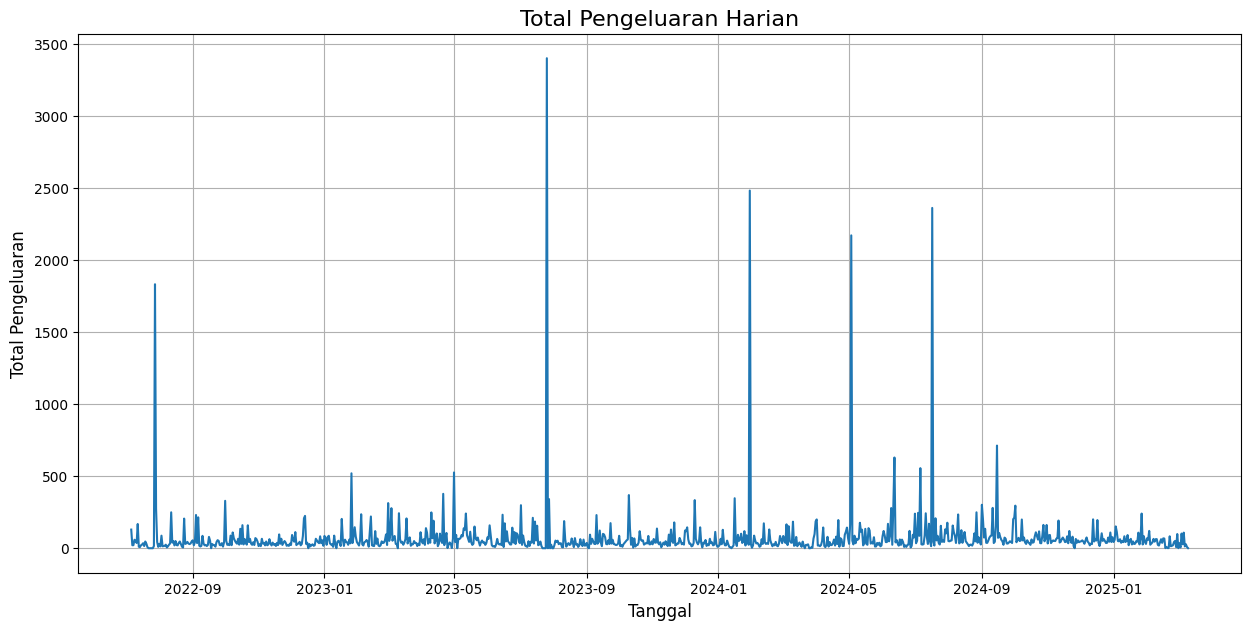

In [2]:
# Muat dataset dan langsung parse kolom 'Date' sebagai datetime
# Gunakan 'engine=python' untuk menghindari potensi error baca file
df = pd.read_csv('Personal Budget Transactions Dataset.csv', parse_dates=['date'], engine='python')

# Kita ubah logika pemilihan pengeluaran di sini:
# Ambil semua baris yang kategorinya BUKAN 'Income'
df_expense = df[df['category'] != 'Income'].copy()

# Agregasi data per hari
# Kita gunakan resample untuk memastikan semua hari ada (yang kosong akan diisi 0)
daily_spending = df_expense.set_index('date').resample('D')['amount'].sum().fillna(0).reset_index()

print("Data Pengeluaran Harian (Time Series):")
# Tampilkan 5 baris pertama yang ada transaksinya untuk verifikasi
display(daily_spending[daily_spending['amount'] > 0].head())


# Visualisasi data harian untuk melihat polanya
plt.figure(figsize=(15, 7))
plt.plot(daily_spending['date'], daily_spending['amount'])
plt.title('Total Pengeluaran Harian', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pengeluaran', fontsize=12)
plt.grid(True)
plt.show()

## 2. Membuat Dataset Supervised Learning (Teknik "Windowing")

Model ML perlu input (`X`) dan target (`y`). Untuk data deret waktu, kita membuatnya dengan teknik "jendela geser" (*sliding window*). Logikanya: **Gunakan data pengeluaran 7 hari terakhir (`X`) untuk menebak pengeluaran di hari ke-8 (`y`)**.

In [3]:
def create_windowed_dataset(series, window_size=7):
    X, y = [], []
    # Kita butuh data series dalam bentuk numpy array
    data = series.to_numpy()
    for i in range(len(data) - window_size):
        # Ambil jendela data sebagai fitur
        X.append(data[i:(i + window_size)])
        # Ambil data setelah jendela sebagai label
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Ekstrak hanya kolom 'Amount' untuk dijadikan series
spending_series = daily_spending['amount']

# Tentukan ukuran jendela (misal: 7 hari)
WINDOW_SIZE = 7

# Buat dataset X dan y
X, y = create_windowed_dataset(spending_series, window_size=WINDOW_SIZE)

print(f"Bentuk X (data latih): {X.shape}")
print(f"Bentuk y (data target): {y.shape}")
print("\nContoh X pertama:", X[0])
print("Contoh y pertama:", y[0])

Bentuk X (data latih): (973, 7)
Bentuk y (data target): (973,)

Contoh X pertama: [129.38  20.73  21.02  58.7   51.    36.38 168.2 ]
Contoh y pertama: 10.4


## 3. Scaling dan Pembagian Data

Jaringan Saraf Tiruan sangat sensitif terhadap skala data. Kita akan mengubah semua nilai menjadi rentang antara 0 dan 1 menggunakan `MinMaxScaler`. Kemudian, kita bagi data menjadi set latih dan uji.

In [4]:
# Bagi data sebelum scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # shuffle=False penting untuk data waktu

# Inisialisasi Scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Latih scaler HANYA pada data latih
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Terapkan scaler pada data uji
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Simpan scaler y untuk digunakan saat inferensi nanti
with open('scaler_prediksi.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("Scaler berhasil dibuat dan disimpan sebagai 'scaler_prediksi.pkl'")

Scaler berhasil dibuat dan disimpan sebagai 'scaler_prediksi.pkl'


## 4. Membangun Model Regresi TensorFlow

Sesuai keputusan, kita bangun model Dense Neural Network (DNN) sederhana. Arsitekturnya cukup beberapa lapis Dense dengan aktivasi `relu`, dan satu neuron di lapisan output dengan aktivasi `linear` (default) untuk tugas regresi.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer untuk regresi
])

# Kompilasi model dengan loss function dan optimizer untuk regresi
model.compile(optimizer='adam',
              loss='mean_squared_error', # MSE adalah loss yang umum untuk regresi
              metrics=['mean_absolute_error']) # MAE lebih mudah diinterpretasikan

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


## 5. Melatih Model

Kita latih model dengan data yang sudah di-scaling. Kita gunakan 100 *epoch* dan data validasi untuk memantau performa.

In [6]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=2
)

Epoch 1/100
25/25 - 4s - loss: 0.0040 - mean_absolute_error: 0.0207 - val_loss: 4.6855e-04 - val_mean_absolute_error: 0.0156
Epoch 2/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0203 - val_loss: 4.7001e-04 - val_mean_absolute_error: 0.0159
Epoch 3/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0197 - val_loss: 5.3948e-04 - val_mean_absolute_error: 0.0183
Epoch 4/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0203 - val_loss: 5.3255e-04 - val_mean_absolute_error: 0.0181
Epoch 5/100
25/25 - 0s - loss: 0.0038 - mean_absolute_error: 0.0195 - val_loss: 6.0726e-04 - val_mean_absolute_error: 0.0203
Epoch 6/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0202 - val_loss: 4.1145e-04 - val_mean_absolute_error: 0.0119
Epoch 7/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0183 - val_loss: 4.5424e-04 - val_mean_absolute_error: 0.0150
Epoch 8/100
25/25 - 0s - loss: 0.0037 - mean_absolute_error: 0.0200 - val_loss: 4.5967e-04 - val_mean_absolute_error: 0.0149


## 6. Evaluasi Model dan Visualisasi

Setelah dilatih, kita evaluasi performa model pada data uji. Kita akan mengubah kembali hasil prediksi ke skala Rupiah asli agar mudah diinterpretasikan, lalu kita visualisasikan perbandingan antara data asli dan hasil prediksi.


Mean Absolute Error (MAE) pada Data Uji: Rp 45.74
Artinya, rata-rata kesalahan prediksi model adalah sekitar Rp 46 dari nilai sebenarnya.


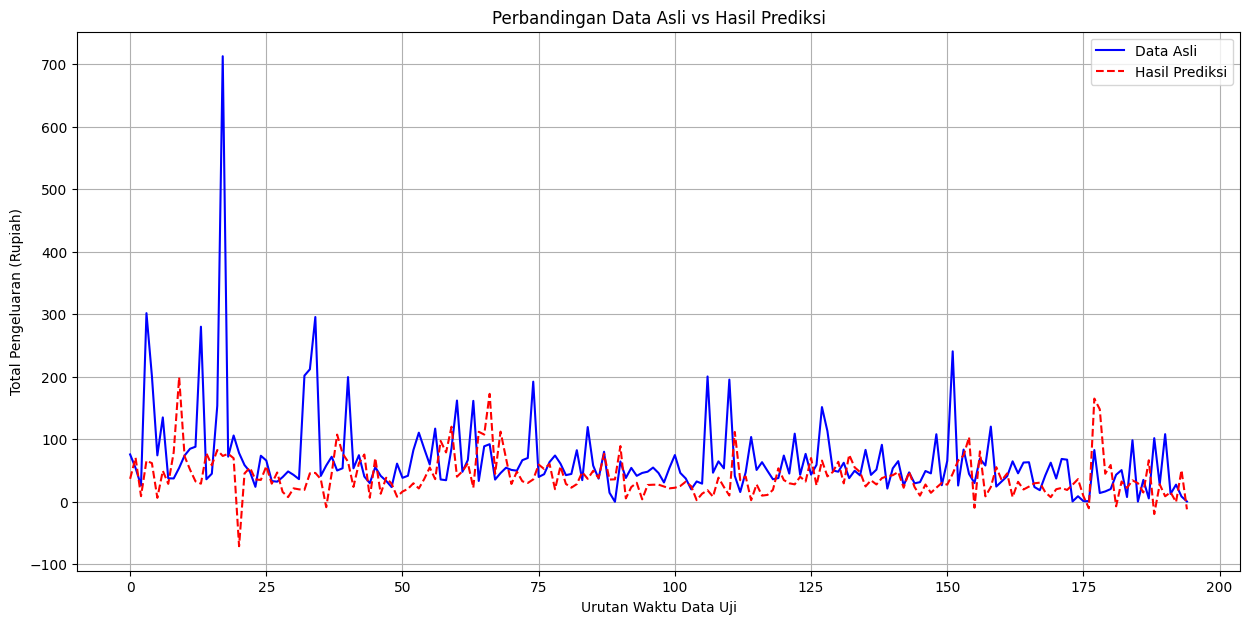

In [7]:
# Lakukan prediksi pada data uji
predictions_scaled = model.predict(X_test_scaled)

# Kembalikan prediksi ke skala Rupiah asli
predictions = scaler_y.inverse_transform(predictions_scaled)

# Kembalikan data uji y ke skala Rupiah asli untuk perbandingan
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# Hitung MAE dan MSE dalam skala Rupiah
mae = tf.keras.losses.mean_absolute_error(y_test_real.flatten(), predictions.flatten()).numpy()
mse = tf.keras.losses.mean_squared_error(y_test_real.flatten(), predictions.flatten()).numpy()

print(f"\nMean Absolute Error (MAE) pada Data Uji: Rp {mae:,.2f}")
print(f"Artinya, rata-rata kesalahan prediksi model adalah sekitar Rp {mae:,.0f} dari nilai sebenarnya.")

# Visualisasi Hasil
plt.figure(figsize=(15, 7))
plt.plot(y_test_real, label='Data Asli', color='blue')
plt.plot(predictions, label='Hasil Prediksi', color='red', linestyle='--')
plt.title('Perbandingan Data Asli vs Hasil Prediksi')
plt.xlabel('Urutan Waktu Data Uji')
plt.ylabel('Total Pengeluaran (Rupiah)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Menyimpan Model dan Scaler

Langkah terakhir, kita simpan model `.keras` dan scaler `.pkl` yang akan digunakan oleh script inferensi.

In [15]:
# Simpan model TensorFlow
model.save('model_prediksi.keras')

print("\nModel berhasil disimpan sebagai 'model_prediksi.keras'")
print("File 'scaler_prediksi.pkl' juga sudah disimpan sebelumnya.")


Model berhasil disimpan sebagai 'model_prediksi.keras'
File 'scaler_prediksi.pkl' juga sudah disimpan sebelumnya.


In [8]:
model.save('model_prediksi.h5')

## Kesimpulan

Kita telah berhasil membangun alur kerja lengkap untuk model prediksi pengeluaran harian. Dimulai dari data transaksi mentah, kita olah menjadi data deret waktu, lalu kita latih sebuah model regresi menggunakan TensorFlow. Model dievaluasi dan menunjukkan performa yang terukur (MAE). Artifak yang disimpan (`.keras` dan `.pkl`) kini siap untuk diintegrasikan untuk membuat fitur prediksi bulanan di aplikasi.